# Maths4DS 101
# Lab 3. Regression and Prediction I

### Describe objectives of the lab

### Please refer to the reference book, chapter 4

[Book Chapter 4](https://learning.oreilly.com/library/view/practical-statistics-for/9781492072935/ch04.html)

### for Q&A please refer to the tags #maths4ds101 and #lab3 on stackoverflow

    
[StackOverflow](https://stackoverflow.com/c/cyberblue/questions/tagged/10)

# 0. Let's Import required Python packages.

In [11]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [12]:
%matplotlib inline

In [13]:
DATA='../data/'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [14]:
LUNG_CSV = DATA + 'LungDisease.csv'
HOUSE_CSV = DATA + 'house_sales.csv'

# 1. Simple Linear Regression
## 1.1 The Regression Equation

In [15]:
lung = pd.read_csv(LUNG_CSV)



In [16]:
lung.head(10)

,PEFR,Exposure
0,390,0
1,410,0
2,430,0
3,460,0
4,420,1
5,280,2
6,420,2
7,520,2
8,610,3
9,590,3


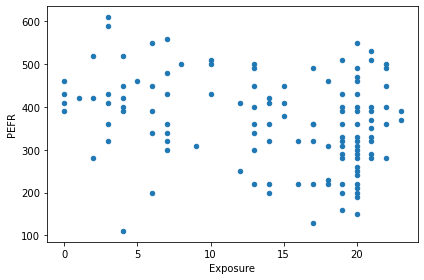

In [17]:
lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

We can use the `LinearRegression` model from _scikit-learn_.

In [18]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583
Coefficient Exposure: -4.185


So the OLS regression line is

$$
\hat{PEFR}=424.583 -4.185 * Exposure
$$


The intercept, or b0, is 424.583 and can be interpreted as the predicted PEFR for a worker with zero years exposure. The regression coefficient, or b1, can be interpreted as follows: for each additional year that a worker is exposed to cotton dust, the worker’s PEFR measurement is reduced by –4.185.

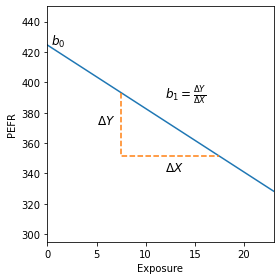

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict([[0], [23]]))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = [[7.5], [17.5]]
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

## 1.2. Fitted Values and Residuals


Important concepts in regression analysis are the fitted values (the predictions) and residuals (prediction errors). In general, the data doesn’t fall exactly on a line, so the regression equation should include an explicit error term ei:


$$
 Y_i=b_0+b_1X_i+e_i
$$


The fitted values, also referred to as the predicted values, are typically denoted by $ Yˆi$ (Y-hat). These are given by:

$$
\hat Yˆ{i}=\hat b_0+\hat b_1X_i
$$

The notation $\hat b_0$ and $\hat b_1$ indicates that the coefficients are estimated versus known.

The method `predict` of a fitted _scikit-learn_ model can be used to predict new data points.

In [20]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

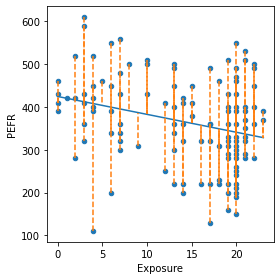

In [21]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

## 1.3. Assessing the model

_Scikit-learn_ provides a number of metrics to determine the quality of a model. Here we use the `r2_score`.

The most important performance metric from a data science perspective is root mean squared error, or RMSE. RMSE is the square root of the average squared error in the predicted $\hat y_i$ values:

In [22]:
fitted = model.predict(lung[predictors])
RMSE = np.sqrt(mean_squared_error(lung[outcome], fitted))

print(f'RMSE: {RMSE:.0f}')


RMSE: 101


Another useful metric that you will see in software output is the coefficient of determination, also called the R-squared statistic or R2. R-squared ranges from 0 to 1 and measures the proportion of variation in the data that is accounted for in the model. It is useful mainly in explanatory uses of regression where you want to assess how well the model fits the data

In [23]:
r2 = r2_score(lung[outcome], fitted)
print(f'r2: {r2:.4f}')

r2: 0.0767


Along with the estimated coefficients, R and statsmodels report the standard error of the coefficients (SE) and a t-statistic. The t-statistic—and its mirror image, the p-value—measures the extent to which a coefficient is “statistically significant”—that is, outside the range of what a random chance arrangement of predictor and target variable might produce. The higher the t-statistic (and the lower the p-value), the more significant the predictor.

In [24]:
model = sm.OLS(lung[outcome], lung[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   PEFR   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     9.974
Date:                Thu, 08 Apr 2021   Prob (F-statistic):            0.00201
Time:                        14:15:43   Log-Likelihood:                -735.68
No. Observations:                 122   AIC:                             1475.
Df Residuals:                     120   BIC:                             1481.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Exposure      -4.1846      1.325     -3.158      0.0

Based on the previous result we conclude that the factor exposure is statistically significant (large negative value of t, p-value close to zero)
We also notice that the confidence interval for Exposure is always negative and thus always different from zero [-6.808, -1.561]